<a href="https://colab.research.google.com/github/Rique3012/TransCal2/blob/main/tumor_transferencia_calor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regime Transiente

//TR Fixo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20                             # Temperatura inicial
S = 1000                            # Taxa de geração interna de calor
R = 1.1                             # Raio do fio
K = 0.5                             # Coeficiente de condução térmica do fio
KI = 0.5 * 100                      # Coeficiente de condução térmica do isolante
alfa = 4
alfaI = 4 * 0.1                     # Difusividade térmica
num_points = 200                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
betaI = alfaI * dt / (dr**2)        # Parâmetro beta do isolante
tempo = 37000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Cria um tensor de shape = (num_points,num_points,nsteps) para armazenar
# todas as informações da simulação
T = np.tile(u,(num_points,1))
T_tensor =T.copy().reshape((num_points,num_points,1))

tempo_array = np.linspace(0, tempo, nsteps-1)
tempo_tensor = tempo_array.copy().reshape((1,1,nsteps-1))

tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)
print(mapa_temporal.shape)

# Simulação
for k in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + (alfa * dt)/K * S

  for i in range(1, num_points - 1):
    raio = i * dr
    if raio < 1:
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + (alfa * dt)/K * S
    else:
      u[i] = (betaI - betaI/(2*i)) * u0[i-1] + (1 - 2*betaI) * u0[i] + (betaI + betaI/(2*i)) * u0[i+1] + (alfaI * dt)/KI

    #raio += dr

    #T = np.tile(u,(num_points,1))
    mapa_temporal[:, :, k] = np.tile(u, (num_points, 1))
    #mapa_temporal[i,:,k] = u[i]

  #print(f"Temperatura média: {np.average(u)}ºC")

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::50]   #200 frames animados

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(theta,r, movie_frames[:,:,0], cmap ='jet', vmin = T0, vmax = np.max(u))
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
#pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    pcm.set_array(movie_frames[:,:,0].ravel())
    return pcm,

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    pcm.set_array(movie_frames[:,:,i].ravel())
    return pcm,

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 50)

#Save the animation as an avi movie file.
anim.save('heatmap_insulated_animation.gif')

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()

(200, 200, 37000)


KeyboardInterrupt: 

GPT DEBUG


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Propriedades biofísicas (legenda: tumor, epidermis, papillary, reticular, subcutaneos, muscle)
ro = np.array([1030, 1200, 1200, 1200, 1000, 1085])  # Densidade [kg/m^3]
c = np.array([3852, 3589, 3300, 3300, 2674, 3800])    # Calor específico [J/(kg.K)]
k = np.array([0.558, 0.235, 0.445, 0.445, 0.185, 0.51])  # Condutividade térmica [W/(m.K)]
alfa = k / (ro * c)  # Difusividade térmica
omega = np.array([0.0063, 0, 0.0002, 0.0013, 0.0001, 0.0027])  # Perfusão sanguínea
Q_bas = np.array([3700, 0, 368.1, 368.1, 368.3, 684.2])  # Taxa metabólica basal [W/m^3]
q = np.array([1.1, 2, 2, 2, 2, 2])  # Fator de ajuste metabólico

# Temperaturas fixas
ta = 37  # Temperatura arterial [°C]
te = 25  # Temperatura externa [°C]

# Funções para cálculo de Q e w
def calc_Q(T, Q_bas, q):
    """Cálculo da taxa metabólica ajustada"""
    return Q_bas * q ** ((T - ta) / 10)

def calc_w(T, omega, q):
    """Cálculo da perfusão sanguínea ajustada"""
    return omega * q ** ((T - ta) / 10)

# Calcula os valores iniciais para w e Q
w = calc_w(ta, omega, q)
Q = calc_Q(ta, Q_bas, q)

# Configuração para o Método das Diferenças Finitas (FDM)
T0 = 25  # Temperatura inicial da superfície da pele [°C]
H_milimeter = 12  # Profundidade da pele [mm]
H = H_milimeter * 10**-3  # Profundidade da pele [m]
dx = 0.000001  # Passo espacial [m]
num_points = int(H / dx)  # Número de pontos na malha espacial
dt = 0.5 * (dx**2) / np.max(alfa)  # Passo temporal [s]

# Limitação para evitar problemas de memória
tempo = 1800  # Tempo total de simulação [s]
nsteps = min(int(tempo / dt), 10000)  # Número de passos de tempo

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)  # Temperatura inicial em todos os pontos
u[-1] = ta  # Condição de contorno na última posição (temperatura arterial)

# Criação da grade para visualização
x = np.linspace(0, H, num_points)
y = np.linspace(0, 0.004, 5)  # Garantir que y tenha dimensões compatíveis com os dados
x, y = np.meshgrid(x, y)

# Criar tensor de temperatura
# T = np.tile(u, (5, 1))  # Ajustar para (5, num_points)
# T_tensor = T.copy().reshape((5, num_points, 1))

T = np.tile(u, (num_points,5))  # Ajustar para (5, num_points)
T_tensor = T.copy().reshape((num_points, 5, 1))

# Criar tensor de tempo
tempo_array = np.linspace(0, tempo, nsteps - 1)
tempo_tensor = tempo_array.copy().reshape((1, 1, nsteps - 1))
tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

# Combinar temperatura e tempo em um mapa temporal
mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)

# Verificar dimensões
print(f"Dimensão de T_tensor: {T_tensor.shape}")
print(f"Dimensão de mapa_temporal: {mapa_temporal.shape}")

# Visualização do campo de temperatura inicial
fig, ax = plt.subplots()
pcm = ax.pcolormesh(x, y, T_tensor[:, :, 0], cmap='jet', vmin=T0, vmax=np.max(u))
fig.colorbar(pcm, ax=ax, label='Temperatura (°C)')
ax.set_title('Distribuição Inicial de Temperatura na Pele')
plt.xlabel('Profundidade (m)')
plt.ylabel('Posição transversal (m)')
plt.show()


ValueError: cannot reshape array of size 720000000 into shape (12000,5,1)

v2

Dimensão de T_tensor: (8496, 5, 1)
Dimensão de mapa_temporal: (8496, 5, 843843)


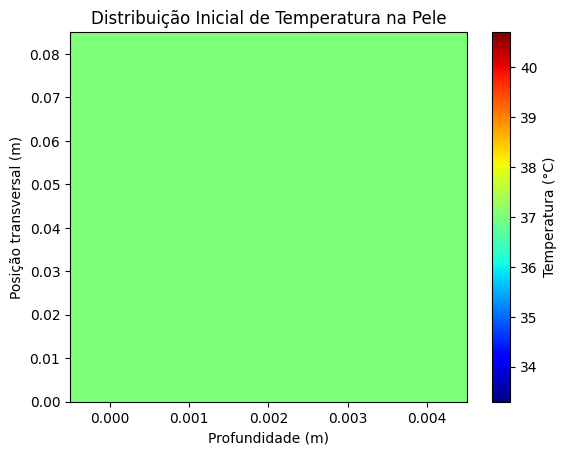

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Propriedades biofísicas (legenda: tumor, epidermis, papillary, reticular, subcutaneos, muscle)
ro = np.array([1030, 1200, 1200, 1200, 1000, 1085])  # Densidade [kg/m^3]
c = np.array([3852, 3589, 3300, 3300, 2674, 3800])    # Calor específico [J/(kg.K)]
k = np.array([0.558, 0.235, 0.445, 0.445, 0.185, 0.51])  # Condutividade térmica [W/(m.K)]
alfa = k / (ro * c)  # Difusividade térmica
omega = np.array([0.0063, 0, 0.0002, 0.0013, 0.0001, 0.0027])  # Perfusão sanguínea
Q_bas = np.array([3700, 0, 368.1, 368.1, 368.3, 684.2])  # Taxa metabólica basal [W/m^3]
q = np.array([1.1, 2, 2, 2, 2, 2])  # Fator de ajuste metabólico

# Defina a ordem das camadas
camadas = [1, 2, 3, 4, 5, 0, 5]  # Ordem: Epidermis, papillary, reticular, subcutanea, muscular, tumor, muscular

# Espessuras das camadas correspondentes [m]
H_layers = np.array([0.001, 0.007, 0.008, 0.02, 0.04, 0.0045, 0.04])  # Espessuras em ordem personalizada
H_layers = H_layers[np.array(camadas)]  # Reordena as espessuras

# Reorganiza as propriedades com base na ordem das camadas
ro = ro[camadas]
c = c[camadas]
k = k[camadas]
omega = omega[camadas]
Q_bas = Q_bas[camadas]
q = q[camadas]

# Temperaturas fixas
ta = 37  # Temperatura arterial [°C]
te = 25  # Temperatura externa [°C]

# Funções para cálculo de Q e w
def calc_Q(T, Q_bas, q):
    """Cálculo da taxa metabólica ajustada"""
    return Q_bas * q ** ((T - ta) / 10)

def calc_w(T, omega, q):
    """Cálculo da perfusão sanguínea ajustada"""
    return omega * q ** ((T - ta) / 10)

# Calcula os valores iniciais para w e Q
w = calc_w(ta, omega, q)
Q = calc_Q(ta, Q_bas, q)

# Configuração para o Método das Diferenças Finitas (FDM)
H_total = np.sum(H_layers)  # Profundidade total [m]
dx = 0.00001  # Passo espacial [m]
num_points_per_layer = (H_layers / dx).astype(int)  # Pontos por camada
num_points = np.sum(num_points_per_layer)  # Total de pontos

dt = 0.5 * (dx**2) / np.max(alfa)  # Passo temporal [s]

# Limitação para evitar problemas de memória
tempo = 300  # Tempo total de simulação [s]
nsteps = min(int(tempo / dt), 1000000)  # Número de passos de tempo

# Inicialização do array de temperatura
u = ta * np.ones(num_points)  # Temperatura inicial
u[-1] = ta  # Condição de contorno

# Função para determinar a camada com base no índice do ponto
def identificar_camada(indice, num_points_per_layer):
    acumulado = 0
    for i, pontos in enumerate(num_points_per_layer):
        acumulado += pontos
        if indice < acumulado:
            return i
    return len(num_points_per_layer) - 1

# Criação da grade para visualização
x = np.linspace(0, H_total, num_points)
y = np.linspace(0, 0.004, 5)
x, y = np.meshgrid(y, x)

# Criar tensor de temperatura
T = np.tile(u, (5, 1))  # Ajustar para (5, num_points)
T_tensor = T.copy().reshape((num_points,5, 1))

# Criar tensor de tempo
tempo_array = np.linspace(0, tempo, nsteps - 1)
tempo_tensor = tempo_array.copy().reshape((1, 1, nsteps - 1))
tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

# Combinar temperatura e tempo em um mapa temporal
mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)

# Verificar dimensões
print(f"Dimensão de T_tensor: {T_tensor.shape}")
print(f"Dimensão de mapa_temporal: {mapa_temporal.shape}")

# Simulação
for k in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + (alfa * dt)/K * S

  for i in range(1, num_points - 1):
    raio = i * dr
    if raio < 1:
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + (alfa * dt)/K * S
    else:
      u[i] = (betaI - betaI/(2*i)) * u0[i-1] + (1 - 2*betaI) * u0[i] + (betaI + betaI/(2*i)) * u0[i+1] + (alfaI * dt)/KI

    #raio += dr

    #T = np.tile(u,(num_points,1))
    mapa_temporal[:, :, k] = np.tile(u, (num_points, 1))
    #mapa_temporal[i,:,k] = u[i]

  #print(f"Temperatura média: {np.average(u)}ºC")

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::50]   #200 frames animados

# Visualização do campo de temperatura inicial
fig, ax = plt.subplots()
pcm = ax.pcolormesh(x, y, T_tensor[:, :, 0], cmap='jet', vmin=ta, vmax=np.max(u))
fig.colorbar(pcm, ax=ax, label='Temperatura (°C)')
ax.set_title('Distribuição Inicial de Temperatura na Pele')
plt.xlabel('Profundidade (m)')
plt.ylabel('Posição transversal (m)')
plt.show()
